## Data cleaning and EDA for tree species

In this notebook, we will do a short exploratory data analysis and clean the data by removing trees with identical coordinates as well as trees outside of the orthophoto range.

The end of this notebook also contains an optional part, that was not used in the project itself. In there, tree distances (in meters) between close trees are calculated. The idea behind this was, that trees in too close proximity (< 3.40 m) will later in the process have images cropped, that might potentially be largely overlapping.



**Data you need for running this notebook:**

The work in this notebook is based on the file "Laubbäume_utm32.csv", that lists all labels and associated tree coordinates.


**Content overview:**



- Setup
- Data cleaning and EDA for tree species
- Clean tree coordinates
- Optional: Find nearest neighbour for each tree and calculate distances


---------

## Setup

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import geopandas as gpd
import math 
import pyproj
from scipy.spatial import KDTree



In [2]:
tree = pd.read_csv('../data/Laubbäume_utm32.csv')

tree.tail(3)

,X,Y,ele,time,desc,route,Unterwuchs,laubholzarten_de_lat_name_lat,laubholzarten_de_lat_gattung,laubholzarten_de_lat_art,laubholzarten_de_lat_kurz
1711,444921.0,5373227.0,15.0,2023/07/11 13:15:42,Rotbuche,7.0,NaN,Fagus sylvatica,Fagus,sylvatica,FaSy
1712,444921.0,5373240.0,12.0,2023/07/11 13:15:59,Rotbuche,7.0,NaN,Fagus sylvatica,Fagus,sylvatica,FaSy
1713,444932.0,5373208.0,15.0,2023/07/11 13:16:10,Rotbuche,7.0,NaN,Fagus sylvatica,Fagus,sylvatica,FaSy


In [3]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   X                              1714 non-null   float64
 1   Y                              1714 non-null   float64
 2   ele                            1703 non-null   float64
 3   time                           1714 non-null   object 
 4   desc                           1714 non-null   object 
 5   route                          1713 non-null   float64
 6   Unterwuchs                     769 non-null    object 
 7   laubholzarten_de_lat_name_lat  1714 non-null   object 
 8   laubholzarten_de_lat_gattung   1714 non-null   object 
 9   laubholzarten_de_lat_art       1714 non-null   object 
 10  laubholzarten_de_lat_kurz      1714 non-null   object 
dtypes: float64(4), object(7)
memory usage: 147.4+ KB


In [4]:
# Format features as date and category
tree['time'] = pd.to_datetime(tree['time']) #format date
tree['desc'] = tree['desc'].astype('category') #format species as category
tree['laubholzarten_de_lat_gattung'] = tree['laubholzarten_de_lat_gattung'].astype('category')

In [5]:
# Check for duplicates
tree.duplicated().value_counts() 

# no duplicates found

False    1714
Name: count, dtype: int64

In [6]:
tree.describe().round().T

,count,mean,min,25%,50%,75%,max,std
X,1714.0,445872.0,443687.0,445119.0,445426.0,446746.0,448278.0,1090.0
Y,1714.0,5372800.0,5369622.0,5372141.0,5372845.0,5373346.0,5374455.0,847.0
ele,1703.0,13.0,1.0,10.0,12.0,15.0,30.0,4.0
time,1714,2023-07-06 04:20:59.667444480,2023-06-26 12:13:01,2023-07-03 08:49:13.249999872,2023-07-06 11:34:21,2023-07-11 09:26:28.249999872,2023-07-11 13:16:10,NaN
route,1713.0,5.0,0.0,3.0,6.0,7.0,7.0,2.0


In [7]:
# Check for NAs in df
tree.isna().sum()


X                                  0
Y                                  0
ele                               11
time                               0
desc                               0
route                              1
Unterwuchs                       945
laubholzarten_de_lat_name_lat      0
laubholzarten_de_lat_gattung       0
laubholzarten_de_lat_art           0
laubholzarten_de_lat_kurz          0
dtype: int64

A lot of information is missing for the category "Unterwuchs"

### Frequency of tree species

In [8]:
# Look at different tree species in the dataset

print(tree['desc'].unique()) #tree species
print(tree['laubholzarten_de_lat_gattung'].unique()) #tree genus

['Birke', 'Rotbuche', 'Sal-Weide', 'Haenge-Birke', 'Vogelbeere', ..., 'Weide', 'Stechpalme', 'Schwarz-Weide', 'Gew. Traubenkirsche', 'Linde']
Length: 25
Categories (25, object): ['Asch-Weide', 'Berg-Ahorn', 'Berg-Ulme', 'Birke', ..., 'Traubeneiche', 'Vogelbeere', 'Vogelkirsche', 'Weide']
['Betula', 'Fagus', 'Salix', 'Sorbus', 'Alnus', ..., 'Aesculus', 'Ulmus', 'Populus', 'Ilex', 'Tilia']
Length: 15
Categories (15, object): ['Acer', 'Aesculus', 'Alnus', 'Betula', ..., 'Sambucus', 'Sorbus', 'Tilia', 'Ulmus']


[Text(0, 0, 'Fagus'),
 Text(1, 0, 'Acer'),
 Text(2, 0, 'Salix'),
 Text(3, 0, 'Betula'),
 Text(4, 0, 'Sorbus'),
 Text(5, 0, 'Alnus'),
 Text(6, 0, 'Quercus'),
 Text(7, 0, 'Corylus'),
 Text(8, 0, 'Aesculus'),
 Text(9, 0, 'Sambucus'),
 Text(10, 0, 'Prunus'),
 Text(11, 0, 'Ulmus'),
 Text(12, 0, 'Ilex'),
 Text(13, 0, 'Populus'),
 Text(14, 0, 'Tilia')]

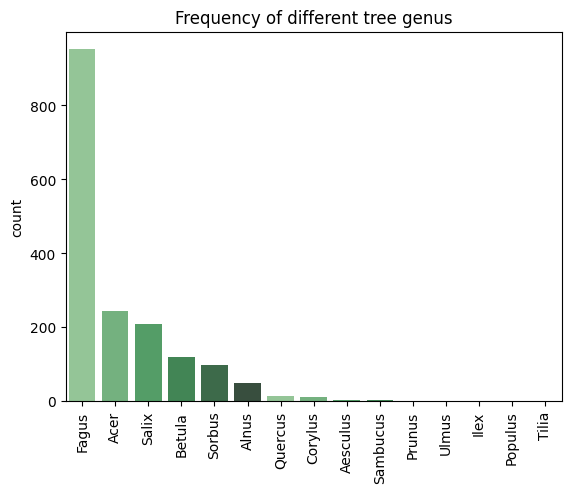

In [9]:
# Plot frequency for each unique genus
pal = sns.color_palette('Greens_d')
p = sns.countplot(data = tree, palette = pal, x='laubholzarten_de_lat_gattung',  order = tree['laubholzarten_de_lat_gattung'].value_counts().index) #x = 'desc', 
p.set(title = 'Frequency of different tree genus', xlabel= '')
p.set_xticklabels(p.get_xticklabels(), rotation = 90)

In [10]:
# Get percentage for each species
new_tree = tree['desc'].value_counts(normalize=True)
new_tree = new_tree.mul(100).rename('Percent').reset_index() 
new_tree

#Rotbuche: 55.5%

,desc,Percent
0,Rotbuche,55.542590
1,Berg-Ahorn,14.177363
2,Sal-Weide,11.843641
3,Haenge-Birke,6.067678
4,Vogelbeere,5.717620
5,Erle,1.400233
6,Moor-Birke,0.875146
7,Grau-Erle,0.816803
8,Schwarz-Erle,0.700117
9,Gem. Hasel,0.700117


[Text(0, 0, 'Rotbuche'),
 Text(1, 0, 'Berg-Ahorn'),
 Text(2, 0, 'Sal-Weide'),
 Text(3, 0, 'Haenge-Birke'),
 Text(4, 0, 'Vogelbeere'),
 Text(5, 0, 'Erle'),
 Text(6, 0, 'Moor-Birke'),
 Text(7, 0, 'Grau-Erle'),
 Text(8, 0, 'Schwarz-Erle'),
 Text(9, 0, 'Gem. Hasel'),
 Text(10, 0, 'Roteiche'),
 Text(11, 0, 'Traubeneiche'),
 Text(12, 0, 'Rosskastanie'),
 Text(13, 0, 'Schwarzer Holunder'),
 Text(14, 0, 'Weide'),
 Text(15, 0, 'Birke'),
 Text(16, 0, 'Berg-Ulme'),
 Text(17, 0, 'Linde'),
 Text(18, 0, 'Gew. Traubenkirsche'),
 Text(19, 0, 'Feld-Ahorn'),
 Text(20, 0, 'Schwarz-Weide'),
 Text(21, 0, 'Espe'),
 Text(22, 0, 'Stechpalme'),
 Text(23, 0, 'Vogelkirsche'),
 Text(24, 0, 'Asch-Weide')]

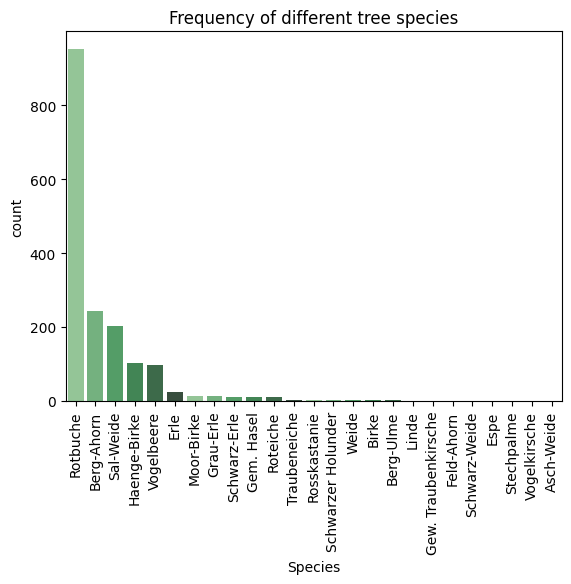

In [11]:
# Plot frequency of all tree species


pal = sns.color_palette('Greens_d')
p = sns.countplot(data = tree, palette = pal, x='desc',  order = tree['desc'].value_counts().index) #x = 'desc', 
p.set(title = 'Frequency of different tree species', xlabel= 'Species')
p.set_xticklabels(p.get_xticklabels(), rotation = 90)

## Height of trees

[Text(0.5, 1.0, 'Elevation = tree height'), Text(0.5, 0, 'Tree height')]

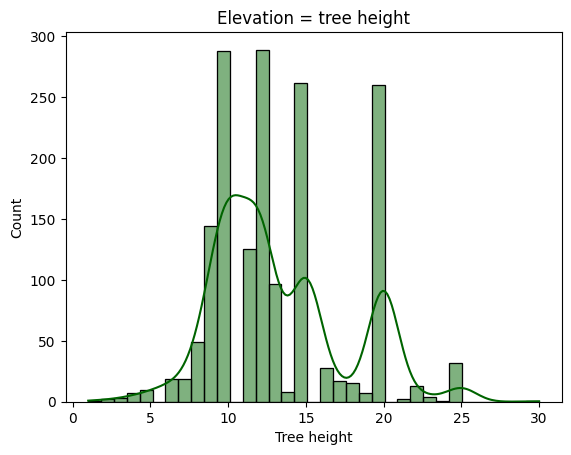

In [12]:
# Plot general distribution of tree heights
p = sns.histplot(data = tree, color = 'darkgreen', x = 'ele', kde=True) #x = 'desc', 
p.set(title = 'Elevation = tree height', xlabel='Tree height')


[Text(0, 0, 'Asch-Weide'),
 Text(1, 0, 'Berg-Ahorn'),
 Text(2, 0, 'Berg-Ulme'),
 Text(3, 0, 'Birke'),
 Text(4, 0, 'Erle'),
 Text(5, 0, 'Espe'),
 Text(6, 0, 'Feld-Ahorn'),
 Text(7, 0, 'Gem. Hasel'),
 Text(8, 0, 'Gew. Traubenkirsche'),
 Text(9, 0, 'Grau-Erle'),
 Text(10, 0, 'Haenge-Birke'),
 Text(11, 0, 'Linde'),
 Text(12, 0, 'Moor-Birke'),
 Text(13, 0, 'Rosskastanie'),
 Text(14, 0, 'Rotbuche'),
 Text(15, 0, 'Roteiche'),
 Text(16, 0, 'Sal-Weide'),
 Text(17, 0, 'Schwarz-Erle'),
 Text(18, 0, 'Schwarz-Weide'),
 Text(19, 0, 'Schwarzer Holunder'),
 Text(20, 0, 'Stechpalme'),
 Text(21, 0, 'Traubeneiche'),
 Text(22, 0, 'Vogelbeere'),
 Text(23, 0, 'Vogelkirsche'),
 Text(24, 0, 'Weide')]

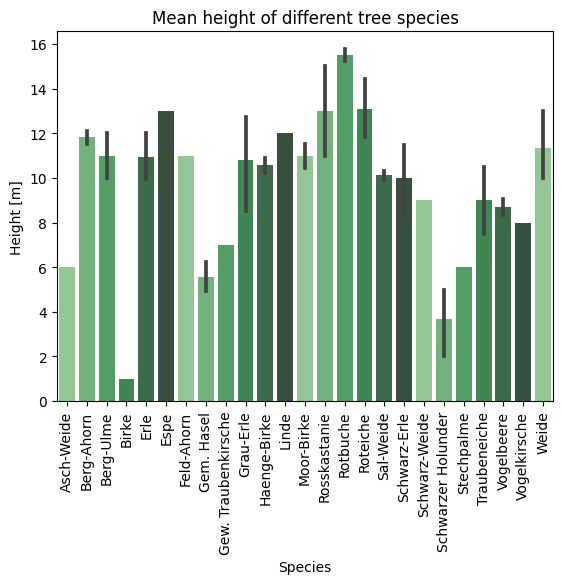

In [13]:
# Plot average height per species
p = sns.barplot(data = tree, palette= pal, x= 'desc', y = 'ele') 
p.set(title = 'Mean height of different tree species', xlabel= 'Species', ylabel= 'Height [m]')
p.set_xticklabels(p.get_xticklabels(), rotation = 90)


## Clean tree coordinates

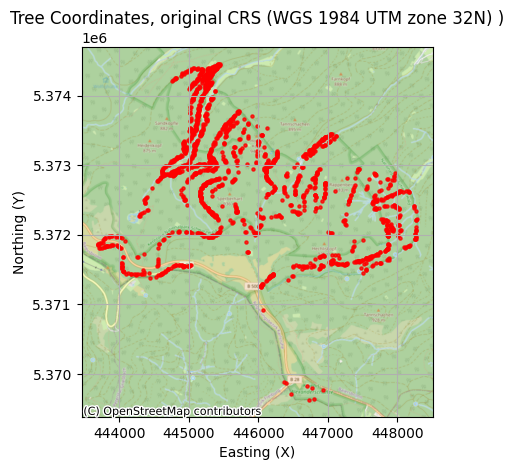

In [14]:
# Convert the df to GeoDataFrame
gdf = gpd.GeoDataFrame(tree, geometry=gpd.points_from_xy(tree['X'], tree['Y']))

# Set coordinate reference system (CRS) for the gdf
gdf.crs = "EPSG:25832"

# Create a scatter plot of UTM coordinates using Matplotlib
plt.scatter(tree['X'], tree['Y'], s=5, c='red', alpha=0.8)
plt.xlabel('Easting (X)')
plt.ylabel('Northing (Y)')
plt.title('Tree Coordinates, original CRS (WGS 1984 UTM zone 32N) )')
plt.grid(True)

# Add a background map using contextily with the same CRS as the UTM coordinates
ctx.add_basemap(ax=plt.gca(), crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

### Remove trees, that are outside of orthophoto range (the ones in the south)

In [15]:
tree_short = tree.iloc[9:]
tree_short.head(2)

,X,Y,ele,time,desc,route,Unterwuchs,laubholzarten_de_lat_name_lat,laubholzarten_de_lat_gattung,laubholzarten_de_lat_art,laubholzarten_de_lat_kurz
9,446039.084777,5.371247e+06,NaN,2023-06-27 13:05:00,Sal-Weide,0.0,NaN,Salix caprea,Salix,caprea,SaCa
10,446029.861131,5.371258e+06,NaN,2023-06-27 13:06:21,Sal-Weide,0.0,NaN,Salix caprea,Salix,caprea,SaCa


### Find and remove trees with identical coordinates


In [16]:
duplicated_rows = tree_short[tree_short.duplicated(subset=['X', 'Y'], keep=False)]
print(duplicated_rows)

                  X             Y   ele                time        desc  \
435   446641.947058  5.372547e+06   9.0 2023-07-03 08:54:15    Rotbuche   
436   446641.947058  5.372547e+06  10.0 2023-07-03 08:54:29        Erle   
1198  445312.920333  5.373029e+06  13.0 2023-07-11 08:25:55  Berg-Ahorn   
1199  445312.920333  5.373029e+06  15.0 2023-07-11 08:26:07    Rotbuche   

      route Unterwuchs laubholzarten_de_lat_name_lat  \
435     3.0         ja               Fagus sylvatica   
436     3.0        NaN                   Alnus spec.   
1198    7.0         ja           Acer pseudoplatanus   
1199    7.0        NaN               Fagus sylvatica   

     laubholzarten_de_lat_gattung laubholzarten_de_lat_art  \
435                         Fagus                sylvatica   
436                         Alnus                    spec.   
1198                         Acer           pseudoplatanus   
1199                        Fagus                sylvatica   

     laubholzarten_de_lat_kurz  

In [17]:
tree_cleaned = tree_short.drop_duplicates(subset=['X', 'Y'], keep='first')
duplicated_rows_tree_cleaned = tree_cleaned[tree_cleaned.duplicated(subset=['X', 'Y'], keep=False)]
print(duplicated_rows_tree_cleaned) #now there are no duplicates left

Empty DataFrame
Columns: [X, Y, ele, time, desc, route, Unterwuchs, laubholzarten_de_lat_name_lat, laubholzarten_de_lat_gattung, laubholzarten_de_lat_art, laubholzarten_de_lat_kurz]
Index: []


In [18]:
# Double check that trees are removed
print(len(tree), len(tree_short), len(tree_cleaned)) #chech length of dfs

1714 1705 1703


In [19]:
#Export cleaned tree data to csv
tree_cleaned.to_csv('../data/Laubbäume_utm32_cleaned.csv', index=False)

## Optional: Calculate distance between trees

The idea behind this is, that tree that are standing too close together will have an overlap of the extracted images later on.
Here we check how many trees are in close distances to each other.

In [20]:
# Define a function to calculate distances, will return distance in meters
def calculate_distance(point1, point2):
    # Define the EPSG codes for the coordinate systems
    from_epsg = "EPSG:25832"
    to_epsg = "EPSG:3857"

    # Iniate transformer
    proj = pyproj.Transformer.from_crs(from_epsg, to_epsg, always_xy=True)

    # Transform the points to EPSG 3857 (WGS 84 / Pseudo-Mercator)
    x1, y1 = proj.transform(point1[0], point1[1])
    x2, y2 = proj.transform(point2[0], point2[1])

    # Calculate distance using Euclidean distance in EPSG 3857
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    return distance

# test it:
point1 = (tree['X'][19], tree['Y'][19])
point2 = (tree['X'][20], tree['Y'][20])

calculate_distance(point1, point2)
# ca 16m. Same as in QGIS for the same points! 

16.17347034142297

## Find nearest neighbours for each tree

In [21]:
tree_coordinates = np.array(tree_cleaned[['X', 'Y']])

In [22]:
# Use a k-dimensional tree

def find_top_n_closest_trees(tree_coordinates, top_candidates=3):
    
    kdtree = KDTree(tree_coordinates) # Create a KDTree

    tree_candidates_list = []

    # Iterate through all trees and get top N closest trees (by distance)
    for tree_idx, tree_coordinate in enumerate(tree_coordinates):
        closest_indices = kdtree.query(tree_coordinate, k=top_candidates+1)[1]
        closest_indices = closest_indices[1:]  # Exclude the first element, which is the tree itself

        # Collect all information:
        top_n_closest_coordinates = tree_coordinates[closest_indices]  # Get coordinates of closest trees
        distances = [calculate_distance(tree_coordinate, other_tree_coordinate) for other_tree_coordinate in top_n_closest_coordinates]  # Calculate distances between trees

        # Store candidate info for this tree
        candidate_info_list = []

        for i, other_tree_idx in enumerate(closest_indices):
            distance = distances[i]

            # Create a dictionary with all information
            candidate_info = {
                'X': tree_coordinate[0],
                'Y': tree_coordinate[1],
                'closest_tree_X': top_n_closest_coordinates[i][0],
                'closest_tree_Y': top_n_closest_coordinates[i][1],
                'distance': distance,
            }

            
            candidate_info_list.append(candidate_info) # Append candidate to list for this tree
        
        tree_candidates_list.append(candidate_info_list) # Append list of candidates to tree df

    return tree_candidates_list

In [23]:
# Create list of each tree with its top N candidates
tree_candidates_list = find_top_n_closest_trees(tree_coordinates, top_candidates=3)

# Flatten list
flattened_candidates_list = [candidate for sublist in tree_candidates_list for candidate in sublist]
candidate_df = pd.DataFrame.from_records(flattened_candidates_list)

# Merge with tree df
merged_top_candidates = pd.merge(tree_short, candidate_df, on=['X', 'Y'], how='left')

# Export if necessary
# merged_top_candidates.to_csv('../data/merged_top_candidates.csv') #



In [24]:
# Filter for all tree pairs, that are closer togehter than 3.40 meters:
trees_within_distance = merged_top_candidates[merged_top_candidates['distance'] <= 3.40]

# Group by tree coordinates (X and Y) and count the number of candidates within distance
candidate_count = trees_within_distance.groupby(['X', 'Y']).size().reset_index(name='Candidate_Count')
candidate_count.describe().T

,count,mean,std,min,25%,50%,75%,max
X,59.0,4.463620e+05,992.020341,4.447035e+05,4.458149e+05,446223.0,4.469604e+05,448017.0
Y,59.0,5.372420e+06,839.058865,5.371268e+06,5.371599e+06,5372575.0,5.372900e+06,5374435.0
Candidate_Count,59.0,1.050847e+00,0.221572,1.000000e+00,1.000000e+00,1.0,1.000000e+00,2.0


In [25]:
# Create a new df with only the relevant columns
trees_within_distance_df = trees_within_distance[['X', 'Y', 'closest_tree_X', 'closest_tree_Y', 'distance']]

unique_pairs_dict = {}

# Loop through the original DataFrame and add unique pairs to the dictionary
for _, row in trees_within_distance_df.iterrows():
    pair = frozenset([row['X'], row['Y'], row['closest_tree_X'], row['closest_tree_Y']])
    if pair not in unique_pairs_dict:
        unique_pairs_dict[pair] = row['distance']

# Find unique pairs of tree matches:

unique_pairs = pd.DataFrame(unique_pairs_dict.items(), columns=['tree_combination', 'distance'])
unique_pairs[['X', 'Y', 'closest_tree_X', 'closest_tree_Y']] = pd.DataFrame(unique_pairs['tree_combination'].tolist(), index=unique_pairs.index)
unique_pairs.drop(columns=['tree_combination'], inplace=True)



In [26]:
# Look at some statistics for the distances
unique_pairs['distance'].round(2).describe().T

count    31.000000
mean      2.596129
std       0.646249
min       1.260000
25%       2.140000
50%       2.790000
75%       3.045000
max       3.380000
Name: distance, dtype: float64

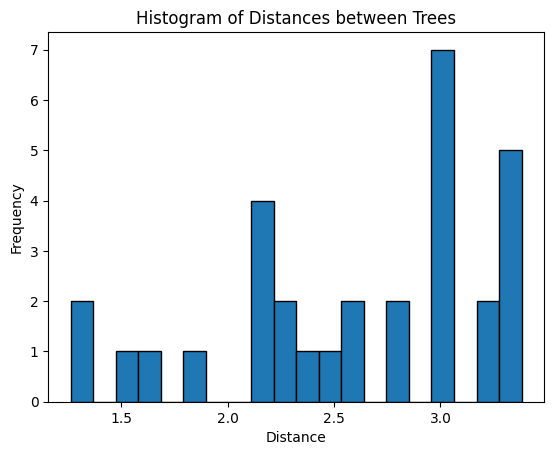

In [27]:
# Plot the distances as a histogram
plt.hist(data = unique_pairs, x='distance', bins=20, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Trees')
plt.show()